### Imports and helper functions

In [1]:
# Boost up training speed using float 16 automatically. (optional for gpu user)
%env TF_ENABLE_AUTO_MIXED_PRECISION=1

env: TF_ENABLE_AUTO_MIXED_PRECISION=1


In [2]:
import crispy as csp
from crispy.core.ecf import *
from crispy.core.emri import *
from crispy.core.eckeras import *

### Set tensorflow gpu (optional for gpu user)

In [3]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


#### Set logger and save the contents into a file.

In [4]:
csp.logger.addHandler(csp.make_file_handler(f'''{cds()}.log'''))
logger = csp.logger

get_ipython().set_custom_exc((Exception,), csp.exception_sound(logger))

In [5]:
# GPU Check (optional for gpu user).
if len(tf.config.list_physical_devices('GPU')) == 0:
    raise Exception("GPU is not available.")
else:
    logger.info(f"GPU is available. {tf.config.list_physical_devices('GPU')}")

GPU is available. [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


#### Get this script to gain reproducible results
https://keras.io/getting-started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development

In [6]:
import numpy as np
import tensorflow as tf
import random as rn

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.

np.random.seed(42)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.

rn.seed(12345)

# Force TensorFlow to use single thread.
# Multiple threads are a potential source of non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/

# session_conf = tf.ConfigProto(intra_op_parallelism_threads=1,
#                               inter_op_parallelism_threads=1)

from tensorflow.keras import backend as K

# The below tf.set_random_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/set_random_seed

tf.random.set_seed(1234)

# sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
# K.set_session(sess)

# Rest of code follows ...

### Set input size
You can adjust input size and batch in accordance with your system.

In [7]:
input_size = [80, 96, 64]
batch_size = 1

## Loading Data


In [8]:
from multiprocessing import Pool, cpu_count, Value, Lock
from ctypes import c_int
import datetime, gzip, bz2
import _pickle as pickle

In [9]:
img_types = ('t1ce','t2', 'flair','t1', 'seg') ; logger.info("img_types: {}".format(img_types))
input_shape = (len(img_types)-1, *input_size) ; logger.info(f"input_shape was set to {input_shape}.")
output_channels = 3 ; logger.info(f"output_channels was set to {output_channels}.")
split_random_state = 42 ; logger.info(f"split random state: {split_random_state}")
save_dir = "."

img_types: ('t1ce', 't2', 'flair', 't1', 'seg')
input_shape was set to (4, 80, 96, 64).
output_channels was set to 3.
split random state: 42


In [10]:
import os
dataset_path=os.path.abspath('data/Brats/MICCAI_BraTS2020_TrainingData/') ; logger.info("dataset_path: {}".format(dataset_path))
iwd=os.getcwd() ; logger.info("iwd: {}".format(iwd))
os.chdir(dataset_path)

dataset_path: D:\Workspace\snubh_follow_up\data\Brats\MICCAI_BraTS2020_TrainingData
iwd: D:\Workspace\snubh_follow_up


In [11]:
# Get a list of files for all modalities individually ### for Brats
root_path='./*/'
t1 = glob.glob(f'{root_path}*t1.nii.gz')
t2 = glob.glob(f'{root_path}*t2.nii.gz')
flair = glob.glob(f'{root_path}*flair.nii.gz')
t1ce = glob.glob(f'{root_path}*t1ce.nii.gz')
seg = glob.glob(f'{root_path}*seg.nii.gz')  # Ground Truth

### Make data_paths for training dataset

In [ ]:
data_paths = [{
    s:item
    for s, item in zip(img_types, items)
}
for items in list(zip(*[globals()[k] for k in img_types]))]

data_paths

#### Make empty arrays for the data

In this notebook, data will be taken into numpy array. Please consider to use tf.dataset API for memory efficiency.

In [13]:
data = np.empty((len(data_paths),) + input_shape, dtype=np.float32)
labels = np.empty((len(data_paths), output_channels) + input_shape[1:], dtype=np.uint8)

### Read nii images and put them into a dictionary

In [14]:
%%time
os.chdir(dataset_path)

nii_dict_list=[]
logged = deepcopy(data_paths)

for i in range(len(data_paths)):
    nii_dict_list.append(read_nii(data_paths[i]))
    print_progressbar(len(data_paths), i)

Progress: [======================== ](100 %) (369/369)                                                                                                
Wall time: 2min 30s


### Cropping original image
In auto_crop function,  
The threshold is calculated by:<br>
&nbsp;&nbsp;&nbsp;&nbsp;min + (max - min) * thresh_percent
    
   If thresh_percent is 0, it means the threshold = min intensity of the image.

In [15]:
%%time

count=0
for i in nii_dict_list:
    data, cr = auto_crop([i[k] for k in img_types], buffer_size=0, thresh_percent = 0)
    for t in img_types:
        i[t] = data[img_types.index(t)]
    logged[count]['crop_range'] = cr
    
    print_progressbar(len(nii_dict_list), count)
    count+=1
    

Progress: [======================== ](100 %) (369/369)                                                                                                
Wall time: 1min 53s


### Check the cropped data

In [ ]:
plot_prediction_result([[i[t] for t in img_types[:-1]] for i in nii_dict_list], 
         [[i[t] for t in img_types[-1:]] for i in nii_dict_list],
                       [[i[t] for t in img_types[-1:]] for i in nii_dict_list],
                       logged = logged,
         arrangement=['d1', 'd2', 'd3', 'd4', 'd1-l1'], chunk_size = 50, save_path = f"{iwd}/{save_dir}/After_auto_crop.png")

## Preprocess the input and put them into numpy arrays
Preprocess step includes:
+ Resizing
+ Normalization(Standardization)

In [17]:
import math

# Parameters for the progress bar
total = len(nii_dict_list)
step = 25 / total

# Assign number to the data
data_w_num=list(enumerate(nii_dict_list))

# Parameters for prepare_data
label_criteria = 'Brats' ; logger.info(f"label_criteria = {label_criteria}")

label_criteria = Brats


In [18]:
tc=TimeChecker()

import multiprocessing as mp

from functools import partial
stride = 369 # The number of image data this code block processes at a time.
ti = arange(0, total, stride)
pr = []
print('total: ' + f'{total}')



for i in range(len(ti)):
    if i == len(ti) - 1 : break
    i1, i2 = ti[i], ti[i+1]
    logger.info(f"The data from {i1+1} to {i2} is being processed...")
    with Pool(cpu_count()) as p:
        partial_pd=partial(prepare_data, resize_output_shape=input_shape[1:], 
                           only_nonzero=False, label_criteria = label_criteria, 
                           label_zoom_order = 0, img_types = img_types) ### Set the arguments of prepare_data function at this!
        r = p.map_async(partial_pd, data_w_num[i1:i2])
        print(f"Number of samples : {total}")
        print("Processing...")
        print(r._number_left, r._chunksize)
        csp.track_job(r, total)
        csp.print_progressbar(total, total-1)
        
        
        r.wait()                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                
        pr.append(r.get())
print('\nAll processes were done.')

preprocessed_data = list(itertools.chain(*pr))

logger.info(f"Elapsed time : {tc.set_and_show()}")

total: 369
The data from 1 to 369 is being processed...
Number of samples : 369
Processing...
62 6
Progress: [======================== ](100 %) (369/369)                                                                                                

All processes were done.
00:01:37.28
Elapsed time : 00:01:37.28


In [19]:
# Return to initial working directory.
os.chdir(iwd)

In [20]:
ixs = np.array(
    list(zip(*preprocessed_data))[0]
        )
assert all(ixs == list(range(total))), "Data has been shuffled."

data = np.array(
    list(zip(*preprocessed_data))[1]
        )

label = np.array(
    list(zip(*preprocessed_data))[2]
        )

In [21]:
del_vars('pr', 'preprocessed_data', 'r', 'data_w_num', main_global = globals())

pr was deleted successfully.
preprocessed_data was deleted successfully.
r was deleted successfully.
data_w_num was deleted successfully.


### Split Data
This code splits the whole dataset into train and validation set only(no test set).

In [22]:
# For Brats data only.
toi = list(range(len(data)))
from sklearn.model_selection import train_test_split
tri, vai = train_test_split(toi, test_size = .2, random_state = 42)

In [23]:
x_train, x_val = data[tri], data[vai]
y_train, y_val = label[tri], label[vai]
l_train, l_val = itemgetter(*tri)(logged), itemgetter(*vai)(logged)

In [24]:
print(x_train.shape,
      x_val.shape)

(295, 4, 80, 96, 64) (74, 4, 80, 96, 64)


### Data Augmentation for train set

#### Set Parameters
- Available augmentation type for **aug_proc** parameter:
  +  br = change_brightness, co = change_contrast, ji = jittering, scale = scale, shift = shift, fl = flip, rr=random_rotation
- Details for **aug_pipe_args**:
  +  br_values(for brightness change) = [factor 1, factor 2]
  +  factors(for contrast change) = [factor 1, factor 2]
  +  ji_ms(for jittering) = [m, s], Noises are drawn from a normal distribution with mean = m, standard deviation = s

In [25]:
epochs = 300 ; logger.info(f"Epochs : {epochs}")
seed_number = 42 ; logger.info(f"seed number : {seed_number}.")
aug_proc = ['scale', 'shift', 'fl'] ; logger.info(f"aug_proc : {aug_proc}")
aug_mode = 'gradual' ; logger.info(f"aug_mode : {aug_mode}")
aug_pipe_args = dict(br_values = [-0.3, 0.3], factors = [1e-5, 1.5], ji_ms = [-25, 9],
                                       only_seg = True, flip_mode='prob') ; logger.info(f"aug_pipe_args : {aug_pipe_args}")
fold_number = None # Because we won't use cross validation

Epochs : 300
seed number : 42.
aug_proc : ['scale', 'shift', 'fl']
aug_mode : gradual
aug_pipe_args : {'br_values': [-0.3, 0.3], 'factors': [1e-05, 1.5], 'ji_ms': [-25, 9], 'only_seg': True, 'flip_mode': 'prob'}


#### Augment data

D:\Workspace\CustomModules\crispy\core\emri.py:429: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(result)[prob]
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Progress: [=========================](100 %) (295/295)                                                                                                
1091 images were generated.
(1091, 4, 80, 96, 64), (1091, 3, 80, 96, 64)
109 samples were dropped because their labels have errors.


D:\Workspace\CustomModules\crispy\core\emri.py:377: RuntimeWarning: invalid value encountered in true_divide
  return np.mean(2 * intersection / dn, axis = 1)


crispy:savepath: Augmented_samples_having_errors_3.png


D:\Workspace\CustomModules\crispy\core\emri.py:501: RuntimeWarning: invalid value encountered in true_divide
  x = max_value * ((x - min_arr) / (max_arr - min_arr))


crispy:savepath: Augmented_samples_having_errors_4.png
x_train.shape: (1277, 4, 80, 96, 64)
y_train.shape: (1277, 3, 80, 96, 64)
ad was deleted successfully.
al was deleted successfully.
KeyError 'nii_dict_list'
KeyError 'nii_dict_list_original'
Data was augmented.
nii_dict_list was deleted successfully.
KeyError 'nii_dict_list_original'


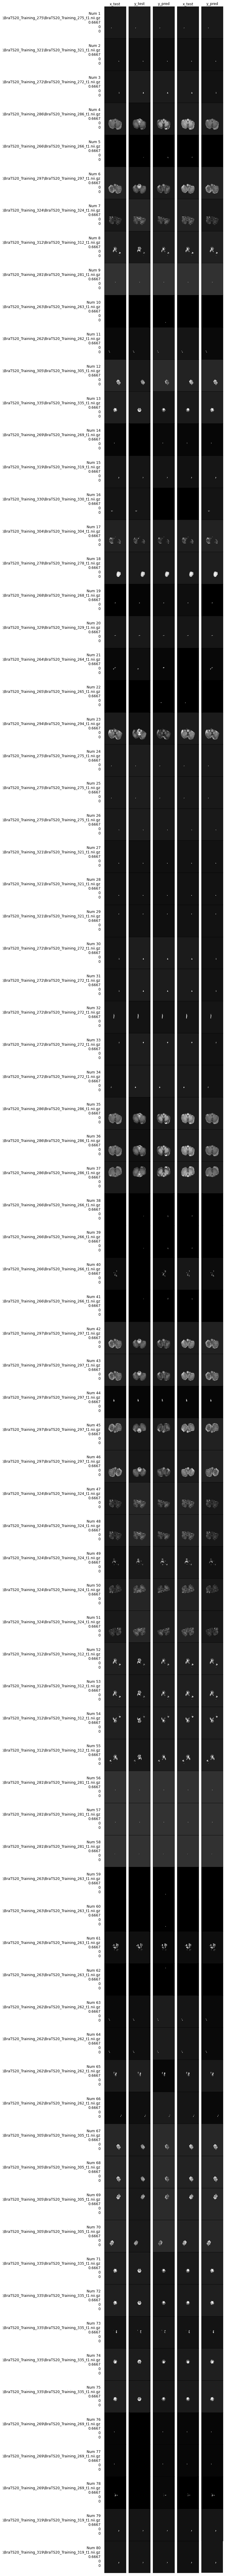

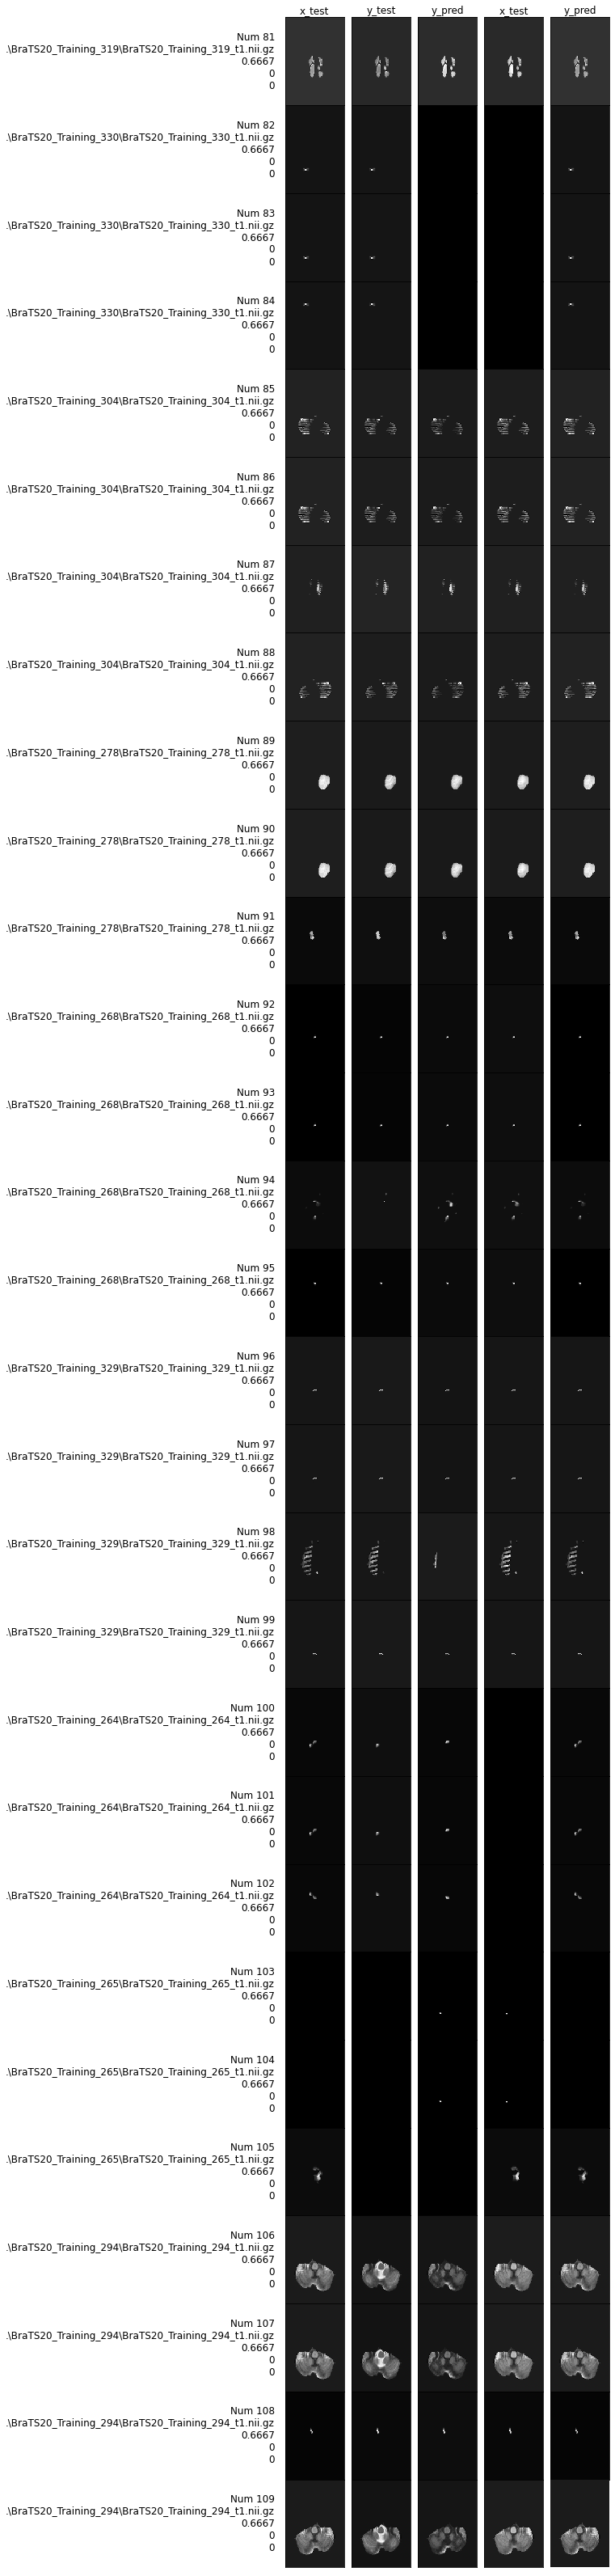

In [26]:
fold_dir = set_fold_dir(save_dir, fold_number)

x_train, y_train, l_train = data_augmentation(x_train, y_train, l_train, aug_proc, aug_mode, aug_pipe_args, save_dir = save_dir, seed_number = seed_number, data_dtype = np.float32)
logger.info(f"Data was augmented.")
del_vars('nii_dict_list', 'nii_dict_list_original', main_global = globals()) # Delete the loaded original data.

x_train, y_train, l_train = truncate_trainset_size(x_train, y_train, l_train, batch_size = batch_size) # If train data is not divisible by batch size, truncate it.

### Make Model

In [27]:
from model_tf2 import conv3d_autoenc_reg, dice_coefficient, DiceLoss
from tensorflow.keras.optimizers import Adam

C:\Users\eck\anaconda3\envs\ml2\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:68: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.2.0 and strictly below 2.4.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.4.0-rc1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


In [28]:
model = conv3d_autoenc_reg(input_shape, output_channels)

### Set Callbacks

#### Learning rate scheduler

In [29]:
def lr_schedule(a0=1e-4, total_epoch=300):

        def lr_schedule_(epoch):
            a=a0*(1-epoch/total_epoch)**0.9

            return a

        return lr_schedule_

lr_scheduler = keras.callbacks.LearningRateScheduler(lr_schedule(1e-4, 300))

#### Other callbacks

In [30]:
monitor = "val_loss"
filename_w = "keras_weight_epoch-{epoch:02d}_" + f"{monitor}" + "-{" + f"{monitor}" +":.4f}.h5"

csv_logger = keras.callbacks.CSVLogger("training_log.csv", append = True)
earlystopping_cb = keras.callbacks.EarlyStopping(monitor=monitor, min_delta = 0.01, patience = 10)
checkpoint_cb_w = keras.callbacks.ModelCheckpoint(filename_w, monitor=monitor, save_weights_only=True)
tensorboard_cb = keras.callbacks.TensorBoard("tensorboard_logs")

In [31]:
callbacks = [tensorboard_cb, checkpoint_cb_w, earlystopping_cb, lr_scheduler, csv_logger]

In [32]:
model.compile(
        Adam(lr=1e-4),
        loss=[DiceLoss()],
        metrics=[dice_coefficient]
    )

### Fit model

In [33]:
history = model.fit(x_train, y_train, batch_size = batch_size, epochs = epochs, callbacks = callbacks, validation_data = (x_val, y_val))

1277/1277 [==============================] - 426s 322ms/step - loss: 0.0985 - dice_coefficient: 0.0165 - val_loss: 0.0439 - val_dice_coefficient: 0.0332


In [34]:
csp.sound_alert()